## 테이블의 내용은 아래의 내용을 담고 있습니다.
1. 고객이 각 귀속년도별
1. 근로 / 사업 / 기타 소득에 대한 예상환급액과 수수료를 조회한 뒤
1. 결제를 하거나 하지 않은 여부를 저장


## 아래의 질문에 나름의 방식으로 답을 찾아주세요.
(정답은 없습니다. 문제를 정의하고, 해답에 이르게 된 과정과 그 해석을 잘 설득/설명해 주시는 것이 중요합니다.)

- 고객의 결제여부에 영향을 미치는 요인들은 무엇인가요? 
- 고객의 수수료 결제금액의 합을 높히기 위해서는 어떻게 해야 할까요?

# 라이브러리 

In [75]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

import numpy as np

import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf


# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [76]:
## 시각화를 위한 폰트설정
# 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = "NanumGothic"
print(plt.rcParams['font.family'])

# 문자 - (마이너스) 정상 출력을 위한 코드
plt.rcParams['axes.unicode_minus'] = False

sns.set(font='NanumGothic', 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

['NanumGothic']


# 데이터 로드

In [294]:
df = pd.read_csv('C:/Users/s/Desktop/wanted_onboarding/Jobis_3o3.csv')

In [295]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   age        100000 non-null  float64
 1   gender     100000 non-null  object 
 2   year       100000 non-null  int64  
 3   refund     100000 non-null  float64
 4   fee        100000 non-null  float64
 5   has_paid   100000 non-null  bool   
 6   income_근로  40791 non-null   float64
 7   income_사업  78227 non-null   float64
 8   income_기타  25260 non-null   float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


In [296]:
# 범주형 변수를 더미 변수로 전환
df = pd.get_dummies(df,columns=['gender','has_paid'])

# 결측값 0으로 대체하기
df = df.fillna(0)

In [297]:
# 데이터 통계 요약 및 이상치 확인 
df.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타,gender_-,gender_F,gender_M,has_paid_False,has_paid_True
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,29.00,2018.11,208142.24,7247.64,2623920.63,1182567.07,160725.19,0.00,0.50,0.50,0.35,0.65
std,7.77,1.50,307174.45,11926.90,5260655.36,2254789.14,795876.14,0.01,0.50,0.50,0.48,0.48
min,15.00,2015.00,-8265000.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,24.00,2017.00,33000.00,400.00,0.00,31000.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,2018.00,99000.00,4300.00,0.00,328000.00,0.00,0.00,0.00,1.00,0.00,1.00
75%,31.00,2019.00,254000.00,8500.00,2994000.00,1235000.00,2000.00,0.00,1.00,1.00,1.00,1.00
max,81.00,2020.00,7725000.00,307000.00,182335000.00,39934000.00,62810000.00,1.00,1.00,1.00,1.00,1.00


## 필요없는 컬럼 drop

In [298]:
df.drop('gender_-', axis=1, inplace=True)
df.drop('gender_F', axis=1, inplace=True)
df.rename({'gender_M':'gender'}, axis=1, inplace=True) # 1=남성, 0=여성
df.drop('has_paid_False',axis=1, inplace=True)
df.rename({'has_paid_True':'has_paid'}, axis=1, inplace=True)
df2 = df[['age','gender','year','refund','fee','has_paid','income_근로','income_사업','income_기타']]
df2

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타
0,27.00,0,2019,5000.00,400.00,0,10001000.00,61000.00,0.00
1,34.00,1,2018,100000.00,1700.00,1,18092000.00,0.00,1815000.00
2,28.00,0,2017,289000.00,11500.00,0,0.00,1461000.00,0.00
3,27.00,1,2019,410000.00,16200.00,0,0.00,2471000.00,0.00
4,26.00,0,2016,114000.00,4300.00,1,0.00,689000.00,0.00
...,...,...,...,...,...,...,...,...,...
99995,27.00,0,2019,301000.00,11900.00,1,0.00,0.00,680000.00
99996,62.00,0,2019,77000.00,1300.00,1,0.00,463000.00,0.00
99997,24.00,1,2020,9000.00,400.00,0,7923000.00,54000.00,0.00
99998,24.00,1,2019,34000.00,400.00,1,0.00,204000.00,0.00


## 컬럼 정보
- age: 고객의 만 나이 
- gender: 고객의 성별(1:남성,0:여성)
- year: 소득이 발생한 연도(귀속년도)
- refund: 예상환급액
- fee: 수수료
- has_paid: 수수료를 결제했는지의 여부(1:True,0:False)
- income_근로: 고객의 근로소득(월급/일용직급여)
- income_사업: 고객의 사업소득(프리랜서 소득)
- income_기타: 고객의 기타소득(그외 기타 소득)

## 데이터 컬럼명 변환

In [299]:
df2 = df2.rename({'age':'나이','gender':'성별','year':'귀속년도','refund':'예상환급액','fee':'수수료','has_paid':'수수료결제여부','income_근로':'근로소득','income_사업':'사업소득','income_기타':'기타소득'}, axis=1)
df2

,나이,성별,귀속년도,예상환급액,수수료,수수료결제여부,근로소득,사업소득,기타소득
0,27.00,0,2019,5000.00,400.00,0,10001000.00,61000.00,0.00
1,34.00,1,2018,100000.00,1700.00,1,18092000.00,0.00,1815000.00
2,28.00,0,2017,289000.00,11500.00,0,0.00,1461000.00,0.00
3,27.00,1,2019,410000.00,16200.00,0,0.00,2471000.00,0.00
4,26.00,0,2016,114000.00,4300.00,1,0.00,689000.00,0.00
...,...,...,...,...,...,...,...,...,...
99995,27.00,0,2019,301000.00,11900.00,1,0.00,0.00,680000.00
99996,62.00,0,2019,77000.00,1300.00,1,0.00,463000.00,0.00
99997,24.00,1,2020,9000.00,400.00,0,7923000.00,54000.00,0.00
99998,24.00,1,2019,34000.00,400.00,1,0.00,204000.00,0.00


# 고객의 결제여부에 영향을 미치는 요인들은? 

## 컬럼 추가

In [300]:
# 근로+사업_소득, 사업+기타_소득, 기타+근로_소득, 총소득 column 추가
df2['근로+사업_소득'] = df2['근로소득']+df2['사업소득']
df2['사업+기타_소득'] = df2['사업소득']+df2['기타소득']
df2['기타+근로_소득'] = df2['기타소득']+df2['근로소득']
df2['총소득'] = df2['근로소득']+df2['사업소득']+df2['기타소득']
df3 = df2.sort_values(['총소득'], ascending = False)
df3.head()

,나이,성별,귀속년도,예상환급액,수수료,수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
51302,53.00,1,2015,262000.00,8500.00,1,182335000.00,1581000.00,2729000.00,183916000.00,4310000.00,185064000.00,186645000.00
83615,53.00,1,2016,219000.00,8500.00,1,170864000.00,1319000.00,1445000.00,172183000.00,2764000.00,172309000.00,173628000.00
82775,53.00,1,2020,373000.00,14500.00,0,164883000.00,220000.00,1617000.00,165103000.00,1837000.00,166500000.00,166720000.00
16756,51.00,1,2018,65000.00,400.00,1,136176000.00,389000.00,0.00,136565000.00,389000.00,136176000.00,136565000.00
80814,40.00,1,2019,228000.00,8900.00,0,107272000.00,213000.00,638000.00,107485000.00,851000.00,107910000.00,108123000.00


## 이상치 제외 후 고려 데이터 축소

In [301]:
# 예상환급액이 총소득보다 높은 고객 데이터 제외
df3.query('예상환급액>=총소득')

,나이,성별,귀속년도,예상환급액,수수료,수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
95364,29.00,1,2020,1864000.00,74000.00,1,0.00,0.00,1729000.00,0.00,1729000.00,1729000.00,1729000.00
87499,36.00,1,2017,1550000.00,61200.00,1,0.00,0.00,1401000.00,0.00,1401000.00,1401000.00,1401000.00
90066,26.00,0,2016,1352000.00,53600.00,1,0.00,29000.00,1258000.00,29000.00,1287000.00,1258000.00,1287000.00
28587,50.00,0,2017,1364000.00,54000.00,0,0.00,0.00,1276000.00,0.00,1276000.00,1276000.00,1276000.00
30806,22.00,0,2017,1364000.00,54000.00,0,0.00,0.00,1276000.00,0.00,1276000.00,1276000.00,1276000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64151,48.00,0,2015,31000.00,400.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
89974,27.00,0,2018,75000.00,2100.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
89975,28.00,1,2017,146000.00,4300.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
64146,20.00,1,2017,27000.00,400.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [302]:
df3 = df3.loc[df3['총소득']>df3['예상환급액']]
df3

,나이,성별,귀속년도,예상환급액,수수료,수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
51302,53.00,1,2015,262000.00,8500.00,1,182335000.00,1581000.00,2729000.00,183916000.00,4310000.00,185064000.00,186645000.00
83615,53.00,1,2016,219000.00,8500.00,1,170864000.00,1319000.00,1445000.00,172183000.00,2764000.00,172309000.00,173628000.00
82775,53.00,1,2020,373000.00,14500.00,0,164883000.00,220000.00,1617000.00,165103000.00,1837000.00,166500000.00,166720000.00
16756,51.00,1,2018,65000.00,400.00,1,136176000.00,389000.00,0.00,136565000.00,389000.00,136176000.00,136565000.00
80814,40.00,1,2019,228000.00,8900.00,0,107272000.00,213000.00,638000.00,107485000.00,851000.00,107910000.00,108123000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37680,21.00,0,2019,2000.00,400.00,1,0.00,13000.00,0.00,13000.00,13000.00,0.00,13000.00
91567,24.00,1,2018,4000.00,400.00,1,0.00,0.00,13000.00,0.00,13000.00,13000.00,13000.00
73633,34.00,0,2016,4000.00,400.00,0,0.00,13000.00,0.00,13000.00,13000.00,0.00,13000.00
75388,29.00,0,2020,4000.00,400.00,0,0.00,0.00,9000.00,0.00,9000.00,9000.00,9000.00


### 삼쩜삼 수수료 책정 방법

✅ 삼쩜삼 수수료 책정 기준

| 예상 환급세액의 10~20%
    
    => (수수료/예상환급액)*100 = 수수료율(%)
 

✅ 연도 별로 고객의 소득에 따른 환급액이 다름

| 신고 연도별로 수수료 책정 후 합산

In [303]:
# 수수료율(=수수료/예상환급액) column 추가
df3.insert(5, '수수료율(%)', round(df3['수수료']/df3['예상환급액'], 4)*100)
df3.head()

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
51302,53.00,1,2015,262000.00,8500.00,3.24,1,182335000.00,1581000.00,2729000.00,183916000.00,4310000.00,185064000.00,186645000.00
83615,53.00,1,2016,219000.00,8500.00,3.88,1,170864000.00,1319000.00,1445000.00,172183000.00,2764000.00,172309000.00,173628000.00
82775,53.00,1,2020,373000.00,14500.00,3.89,0,164883000.00,220000.00,1617000.00,165103000.00,1837000.00,166500000.00,166720000.00
16756,51.00,1,2018,65000.00,400.00,0.62,1,136176000.00,389000.00,0.00,136565000.00,389000.00,136176000.00,136565000.00
80814,40.00,1,2019,228000.00,8900.00,3.90,0,107272000.00,213000.00,638000.00,107485000.00,851000.00,107910000.00,108123000.00


In [304]:
# 수수료율이 100%를 초과하는 고객 데이터 조회
over_rate_df = df3.loc[df3['수수료율(%)']>100]
over_rate_df

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
5809,51.00,1,2017,3000.00,8500.00,283.33,1,23645000.00,1553000.00,264000.00,25198000.00,1817000.00,23909000.00,25462000.00
83440,32.00,1,2019,4000.00,63800.00,1595.00,1,7143000.00,14036000.00,0.00,21179000.00,14036000.00,7143000.00,21179000.00
20961,28.00,1,2019,4000.00,4300.00,107.50,1,14716000.00,574000.00,0.00,15290000.00,574000.00,14716000.00,15290000.00
88014,33.00,1,2018,4000.00,8500.00,212.50,1,12507000.00,2137000.00,483000.00,14644000.00,2620000.00,12990000.00,15127000.00
23370,31.00,0,2019,4000.00,4300.00,107.50,1,14251000.00,446000.00,0.00,14697000.00,446000.00,14251000.00,14697000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94886,34.00,1,2017,6000.00,11100.00,185.00,0,0.00,36000.00,251000.00,36000.00,287000.00,251000.00,287000.00
46742,29.00,1,2019,12000.00,12800.00,106.67,0,0.00,73000.00,213000.00,73000.00,286000.00,213000.00,286000.00
1765,20.00,0,2019,4000.00,8900.00,222.50,1,0.00,26000.00,169000.00,26000.00,195000.00,169000.00,195000.00
55160,30.00,0,2018,4000.00,4300.00,107.50,1,0.00,26000.00,93000.00,26000.00,119000.00,93000.00,119000.00


> 예상환급액<수수료인 수수료율(%)이 100%를 넘어가는 데이터가 발견되어 이상치로 판단하고 고려 데이터에서 제외

In [305]:
# 수수료율이 100% 이하인 데이터만 남기기
df4 = df3.loc[df3['수수료율(%)']<=100]
df4.describe()

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득
count,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00
mean,28.86,0.51,2018.21,214395.63,7546.55,-inf,0.70,2920621.24,1316745.32,176998.50,4237366.56,1493743.82,3097619.73,4414365.06
std,7.70,0.50,1.47,315182.23,12313.94,nan,0.46,5472067.19,2341829.77,837662.37,5687628.04,2438636.38,5609379.00,5799295.53
min,15.00,0.00,2015.00,-8265000.00,400.00,-inf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9000.00
25%,24.00,0.00,2017.00,34000.00,400.00,1.83,0.00,0.00,83000.00,0.00,366000.00,191000.00,0.00,491000.00
50%,27.00,1.00,2018.00,102000.00,4300.00,3.57,1.00,0.00,442000.00,0.00,1701000.00,612000.00,207000.00,1881000.00
75%,31.00,1.00,2020.00,262000.00,8900.00,3.94,1.00,3803000.00,1393000.00,22000.00,6390000.00,1595000.00,4052000.00,6543000.00
max,81.00,1.00,2020.00,7725000.00,307000.00,98.00,1.00,182335000.00,39934000.00,62810000.00,183916000.00,66319000.00,185064000.00,186645000.00


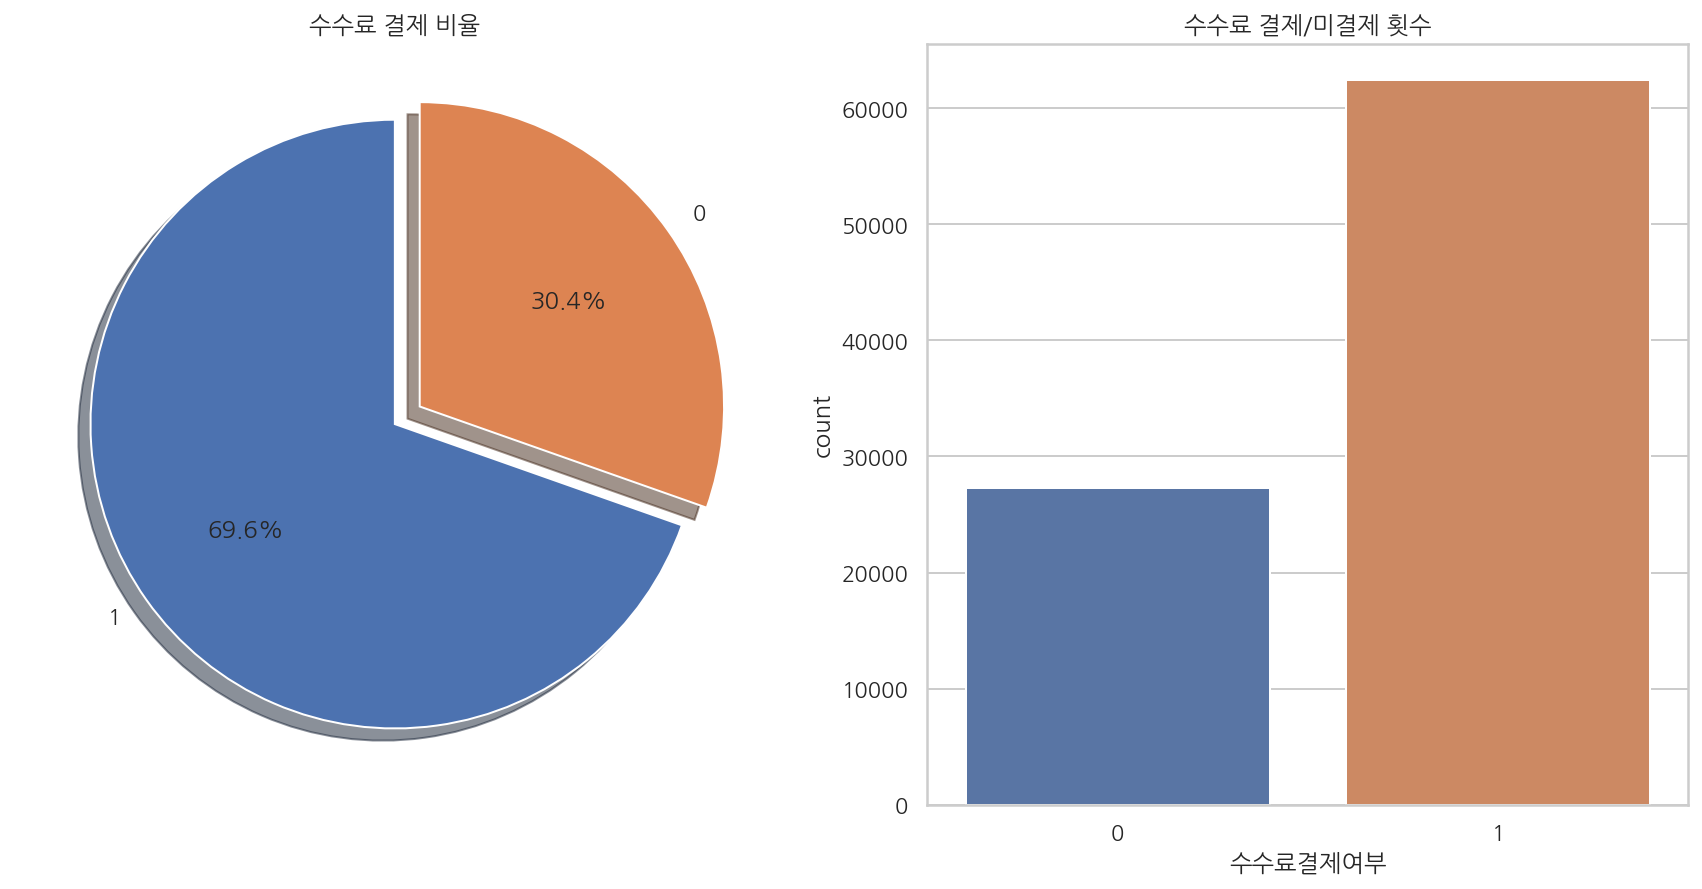

In [306]:
# 수수료 결제, 미결제 분포 확인
sns.set(style='whitegrid', font='NanumGothic')
fig, ax = plt.subplots(1, 2, figsize=(15,7))
df3['수수료결제여부'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0],shadow=True,startangle=90)
ax[0].set_title('수수료 결제 비율') # 파이 그래프 이름
ax[0].set_ylabel('') # 파이 그래프

sns.countplot('수수료결제여부', data=df4, ax=ax[1]) # countplot : 각 카테고리 값별로 데이터가 얼마나 있는지 표시
ax[1].set_title('수수료 결제/미결제 횟수')
plt.show() # 막대 그래프

# 상관 분석(Correlation Analysis)

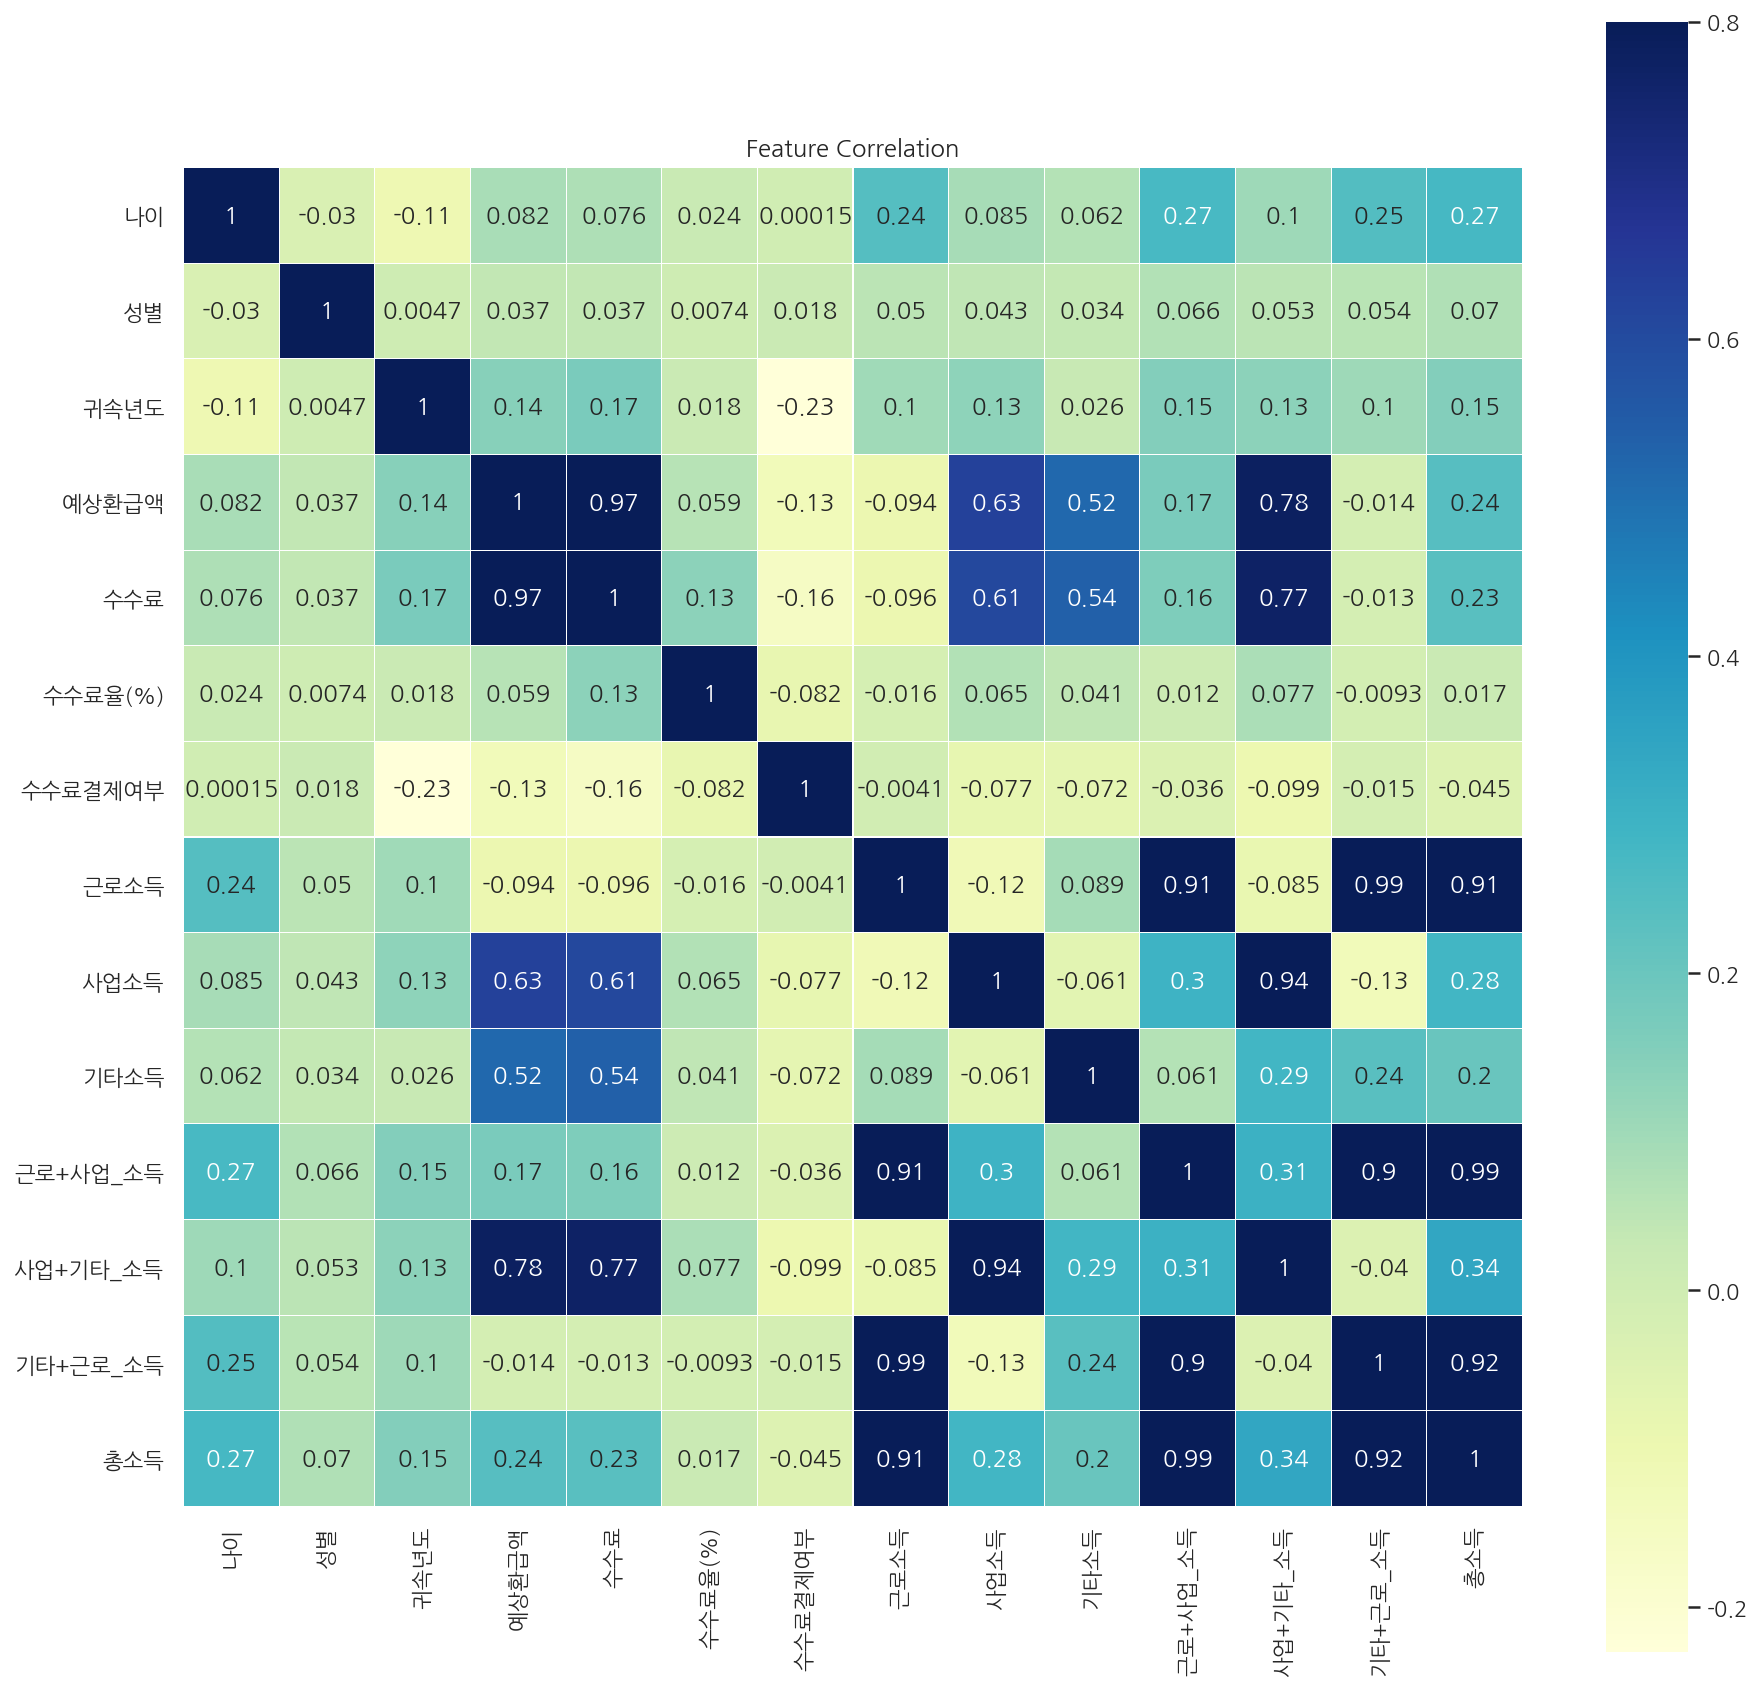

In [307]:
corr = df4.corr()
plt.figure(figsize=(15, 15));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation');

In [308]:
corr_haspaid_list = corr.query("수수료결제여부 > 0.09 or 수수료결제여부 < -0.09").index.values.tolist()
corr_haspaid_list.remove('수수료결제여부')
print(corr_haspaid_list)

['귀속년도', '예상환급액', '수수료', '사업+기타_소득']


> 수수료 결제 여부와 다른 요소들 간에 연관관계가 거의 없는 것으로 보인다. 그나마 수수료, 예상환급액과 각각 -0.16, -0.13로 미세하게 역의 상관관계가 발견된다. 하지만 이는 귀속년도와의 -0.23 상관관계보다 낮은 수치기 때문에 heatmap을 통해서는 유의미한 연관관계가 있다고 단정지을 수 없다.

In [309]:
list1 = df4.columns.to_list()
list1.remove('수수료결제여부')
list1

['나이',
 '성별',
 '귀속년도',
 '예상환급액',
 '수수료',
 '수수료율(%)',
 '근로소득',
 '사업소득',
 '기타소득',
 '근로+사업_소득',
 '사업+기타_소득',
 '기타+근로_소득',
 '총소득']

In [310]:
len(list1)

13

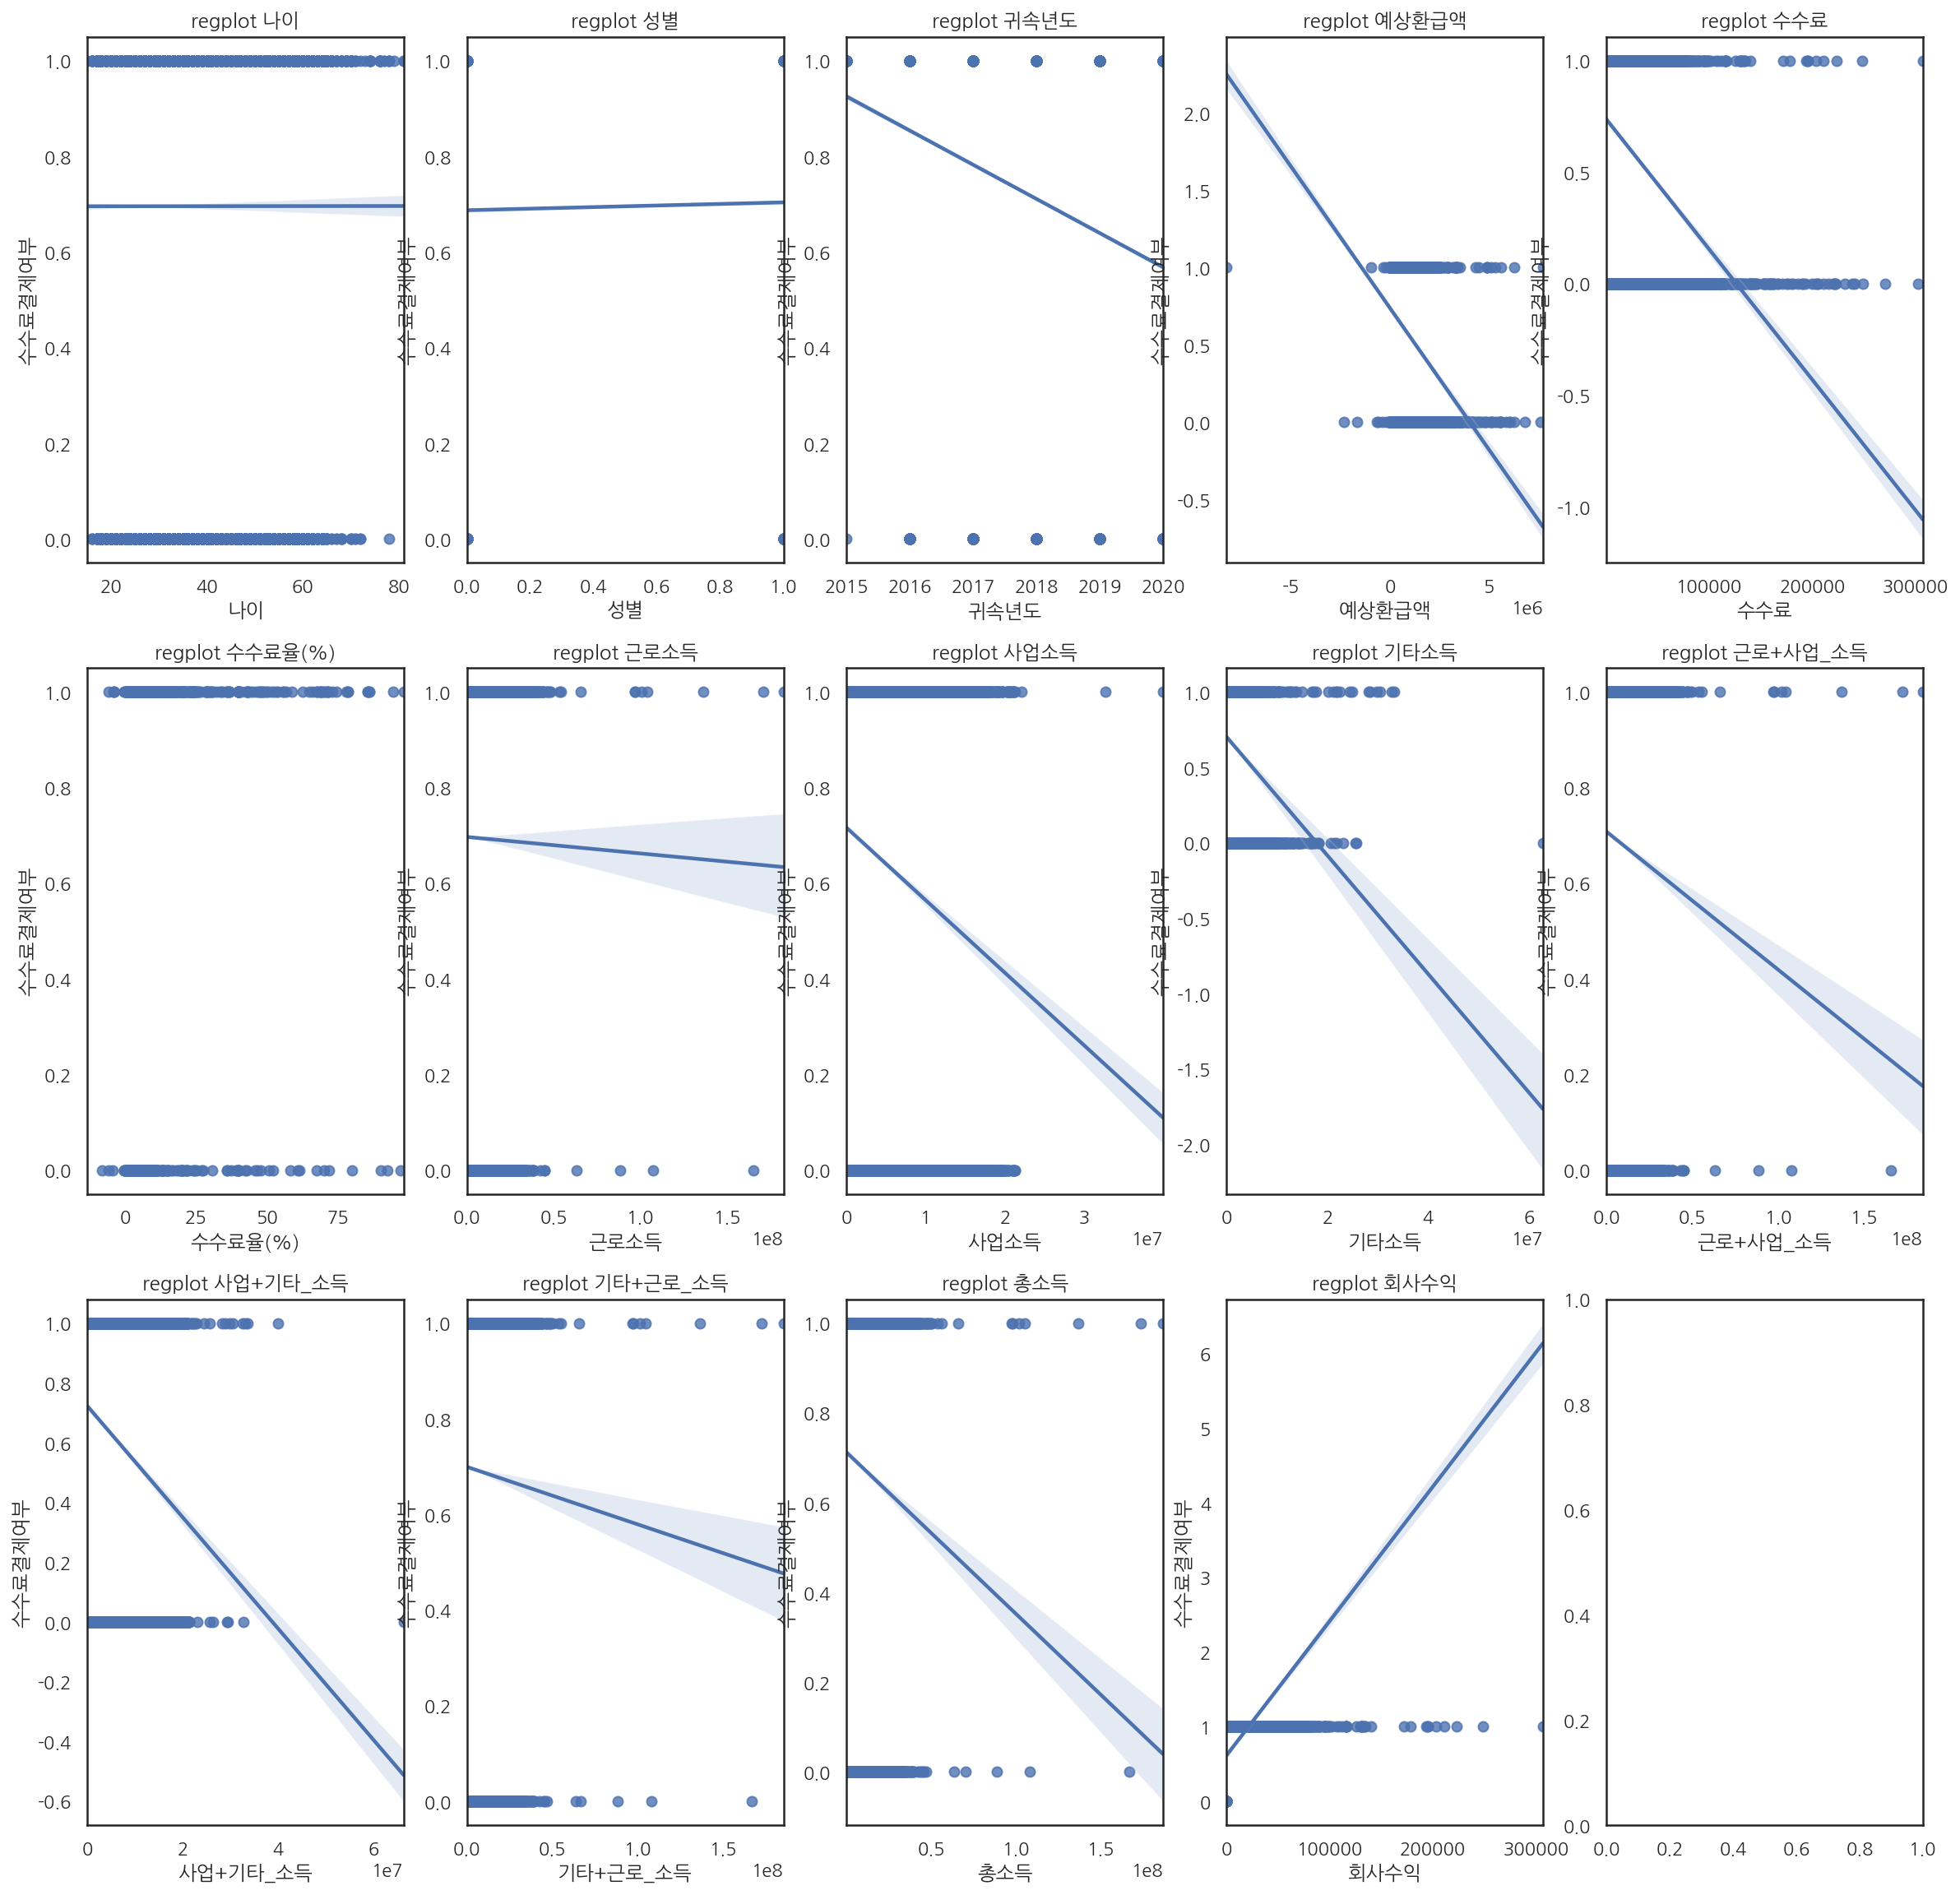

In [232]:
# 수수료결제여부와 다른 항목들 간의 관계를 regression plot을 통해 시각화
figure, ax_list = plt.subplots(nrows=3, ncols=5)
figure.set_size_inches(20,20) 
for i in range(len(list1)): 
    sns.regplot(data=df4, x=list1[i], y='수수료결제여부', ax=ax_list[int(i/5)][int(i%5)]) 
    ax_list[int(i/5)][int(i%5)].set_title("regplot " + list1[i])

> * 수수료가 증가함에 따라 수수료 결제를 하지 않는 경향이 있다.
> * 예상환급액과 수수료결제여부 사이에 뚜렷한 음의 상관관계가 존재한다.

# 수수료 결제 여부 예측 모델
> => 수수료결제여부를 기대값으로 하는 기대값 최대화 알고리즘(expectation-maximization algorithm)

In [355]:
df4.describe()

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
count,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00,89745.00
mean,28.86,0.51,2018.21,214395.63,7546.55,-inf,0.70,2920621.24,1316745.32,176998.50,4237366.56,1493743.82,3097619.73,4414365.06,4364.25
std,7.70,0.50,1.47,315182.23,12313.94,nan,0.46,5472067.19,2341829.77,837662.37,5687628.04,2438636.38,5609379.00,5799295.53,8587.84
min,15.00,0.00,2015.00,-8265000.00,400.00,-inf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9000.00,0.00
25%,24.00,0.00,2017.00,34000.00,400.00,1.83,0.00,0.00,83000.00,0.00,366000.00,191000.00,0.00,491000.00,0.00
50%,27.00,1.00,2018.00,102000.00,4300.00,3.57,1.00,0.00,442000.00,0.00,1701000.00,612000.00,207000.00,1881000.00,400.00
75%,31.00,1.00,2020.00,262000.00,8900.00,3.94,1.00,3803000.00,1393000.00,22000.00,6390000.00,1595000.00,4052000.00,6543000.00,5100.00
max,81.00,1.00,2020.00,7725000.00,307000.00,98.00,1.00,182335000.00,39934000.00,62810000.00,183916000.00,66319000.00,185064000.00,186645000.00,307000.00


## WMAE 손실함수 정의
* 수수료 결제여부에 미치는 영향이 비교적 큰 수수료의 상위 25% 기준이 되는 8900 이상일 경우 가중치를 부여
>
* 독립변수로 예상환급액, 수수료, 근로소득, 기타소득, 기타+근로_소득을 적용했을 때 결과
> * 가중치 3; WMAE:62.71, accuracy: 61.575
> * 가중치 5; WMAE:60.97, accuracy: 62.08
> * 가중치 10; WMAE:60.82, accuracy: 62.21
> * 가중치 15; WMAE:61.04, accuracy: 62.045
> * 가중치 20; WMAE:60.52, accuracy: 61.755
> * 가중치 25; WMAE:60.65, accuracy: 61.53

* 독립변수로 예상환급액, 수수료을 적용했을 때 결과
> * 가중치 20; WMAE:70.37, accuracy: 64.17

* 독립변수로 귀속년도, 예상환급액, 수수료을 적용했을 때 결과
> * 가중치 20; WMAE:54.33, accuracy: 70.11

* * 독립변수로 귀속년도, 예상환급액, 수수료, 사업+기타_소득을 적용했을 때 결과
> * 가중치 20; WMAE:52.71, accuracy: 67.21

In [312]:
def WMAE(dataset, real, predicted):
    weights = dataset.수수료.apply(lambda x: 20 if x>8900 else 1)
    
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## training data 준비

In [313]:
X_train = df4[['귀속년도','예상환급액','수수료']]
Y_train = df4['수수료결제여부']

## Random Forest Estimator 선언 후 학습 및 예측

In [314]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score # 정확도 함수

In [315]:
# 학습 & 예측 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
# 학습 진행
RFC = RandomForestClassifier(n_estimators=30, max_depth=100)
RFC.fit(x_train, y_train)
# 예측
predicted = RFC.predict(x_test)
print(predicted)

[1 1 1 ... 0 1 1]


## training error 측정

In [316]:
print('WMAE :', WMAE(x_test, y_test, predicted))

WMAE : 51.51


## test data에 대한 예측 수행

In [317]:
X_test = df4[['귀속년도','예상환급액','수수료']]
predict = RFC.predict(X_test)
print(predict)
print(accuracy_score(y_test,predicted))

[1 1 0 ... 1 0 1]
0.6949133656471113


# 고객의 수수료 결제금액의 합을 높이려면?

## 고객 후기


### 긍정

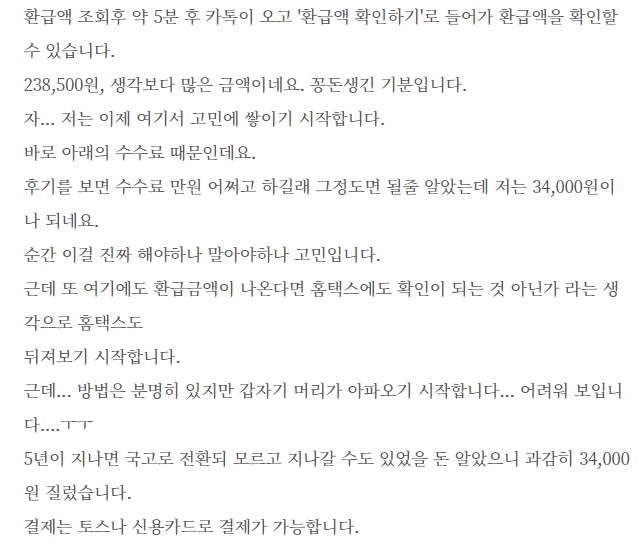

### 부정

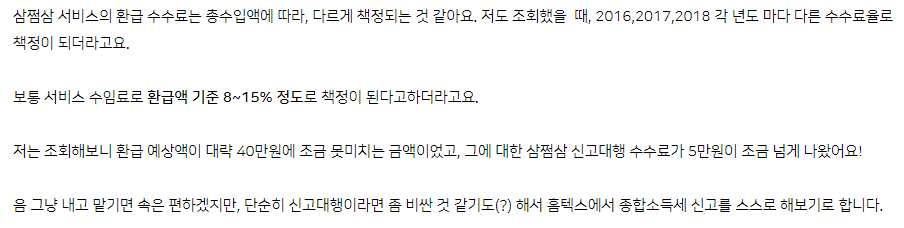

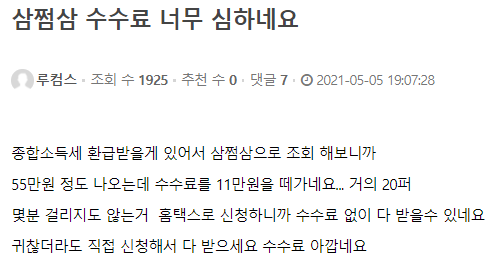

> 고객 후기를 종합해보면 삼쩜삼 세금 환급 서비스로 빠르고 간편하게 환급액을 조회할 수 있다는 점은 긍정적인 반응이 대부분입니다. 이후 환급예상액에 따른 수수료를 확인한 뒤에 반응이 갈렸습니다. 국세청홈텍스에 들어가서 직접 신고하는 과정을 모르거나 복잡하여 귀찮게 여기는 고객들은 수수료를 결제하는 반면, 수수료가 지나치게 높다고 여기는 고객들은 수료를 결제하지 않는 모습을 보이고 있습니다. 이는 위에서 수수료결제여부와 수수료 간의 음의 상관관계가 있음을 대변하는 행태라고 볼 수 있겠습니다.

```따라서 고객의 수수료 결제금액의 합을 늘리려면 환급예상액만 조회한 후 홈텍스에서 직접 신고하는 고객들의 이탈을 최대한 억제하게끔 수수료를 책정해야 합니다. 동시에 회사수익을 극대화 하려면 수수료를 어느 정도 높이는 게 유리할 것으로 보여, 적정한 수준의 수수료를 책정하는 게 중요함을 알 수 있습니다.```
* 수수료 결제금액의 합 = 회사수익
* 기대회사수익 = E(X)
* x_i = 개별 고객들의 수수료
* p(z∣x_i) = 조건부기대수수료결제율
* 회사수익 극대화: max E(X) = max Σ(x_i)(p(z∣x_i)) 
* 이때, 수수료와 조건부기대수수료결제율 사이에는 음의 상관관계가 있으므로 양값의 조율이 필요
* ```최대 수익을 구하는 알고리즘 구축 => Expectation Maximization Algorithm```

# 회사 수익

In [356]:
# 회사 수익(=수수료*결제여부) column 추가
df4['회사수익'] = df4['수수료']*df4['수수료결제여부']

### 🤷‍♂️ "신고했는데 환급 못받으면 제 수수료는요..?" 

### 🙆 만약 수수료 결제 후 부양 가족 등의 이유로 환급이 아닌 납부가 된다거나, 환급액이 없는 경우 신고를 진행하지 않고 💥결제하신 수수료 전액 환불💥해드립니다. 

### 예상환급액이 0이거나 마이너스인 고객들 데이터: 76명

In [357]:
fee_refund_df = df4.loc[df4['예상환급액']<=0]
fee_refund_df

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
29515,41.00,0,2017,-10000.00,400.00,-4.00,1,19718000.00,162000.00,128000.00,19880000.00,290000.00,19846000.00,20008000.00,400.00
57756,38.00,0,2017,-107000.00,4300.00,-4.02,1,16619000.00,737000.00,0.00,17356000.00,737000.00,16619000.00,17356000.00,4300.00
52858,34.00,1,2017,-2328000.00,400.00,-0.02,0,16759000.00,28000.00,441000.00,16787000.00,469000.00,17200000.00,17228000.00,0.00
94281,39.00,0,2020,-683000.00,39100.00,-5.72,0,6082000.00,10649000.00,0.00,16731000.00,10649000.00,6082000.00,16731000.00,0.00
54256,48.00,0,2018,-948000.00,3000.00,-0.32,1,8157000.00,3975000.00,0.00,12132000.00,3975000.00,8157000.00,12132000.00,3000.00
82203,32.00,1,2018,-89000.00,3800.00,-4.27,0,9982000.00,1095000.00,425000.00,11077000.00,1520000.00,10407000.00,11502000.00,0.00
55168,28.00,0,2020,-1658000.00,1700.00,-0.10,0,10509000.00,570000.00,0.00,11079000.00,570000.00,10509000.00,11079000.00,0.00
10034,34.00,1,2015,-231000.00,8500.00,-3.68,1,8989000.00,1714000.00,0.00,10703000.00,1714000.00,8989000.00,10703000.00,8500.00
83050,33.00,1,2017,-175000.00,400.00,-0.23,0,8242000.00,386000.00,289000.00,8628000.00,675000.00,8531000.00,8917000.00,0.00
70198,28.00,1,2020,-583000.00,900.00,-0.15,0,8389000.00,298000.00,0.00,8687000.00,298000.00,8389000.00,8687000.00,0.00


In [364]:
# 회사수익이 0인 고객 데이터
zero_profit_df = df4.loc[df4['회사수익']==0]
zero_profit_df

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
82775,53.00,1,2020,373000.00,14500.00,3.89,0,164883000.00,220000.00,1617000.00,165103000.00,1837000.00,166500000.00,166720000.00,0.00
80814,40.00,1,2019,228000.00,8900.00,3.90,0,107272000.00,213000.00,638000.00,107485000.00,851000.00,107910000.00,108123000.00,0.00
61071,51.00,1,2020,21000.00,400.00,1.90,0,88358000.00,59000.00,0.00,88417000.00,59000.00,88358000.00,88417000.00,0.00
17003,42.00,1,2020,6054000.00,240600.00,3.97,0,3890000.00,3509000.00,62810000.00,7399000.00,66319000.00,66700000.00,70209000.00,0.00
41667,42.00,1,2018,169000.00,6400.00,3.79,0,62975000.00,0.00,553000.00,62975000.00,553000.00,63528000.00,63528000.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52600,24.00,1,2018,15000.00,400.00,2.67,0,0.00,0.00,18000.00,0.00,18000.00,18000.00,18000.00,0.00
54071,24.00,1,2019,8000.00,400.00,5.00,0,0.00,0.00,18000.00,0.00,18000.00,18000.00,18000.00,0.00
97732,26.00,1,2018,5000.00,400.00,8.00,0,0.00,0.00,15000.00,0.00,15000.00,15000.00,15000.00,0.00
73633,34.00,0,2016,4000.00,400.00,10.00,0,0.00,13000.00,0.00,13000.00,13000.00,0.00,13000.00,0.00


### 회사수익에서 예상환급액이 0이하인 고객들에게 환불해야할 수수료 결제금액 제거

In [320]:
plus_refund_df = df4.loc[df4['예상환급액']>0]

# 회사 수익이 플러스인 행들만 남기기
plus_profit_df = plus_refund_df.loc[plus_refund_df['회사수익']>0]
plus_profit_df.sort_values('회사수익', ascending=False)

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
61745,25.00,0,2018,7725000.00,307000.00,3.97,1,2850000.00,0.00,17297000.00,2850000.00,17297000.00,20147000.00,20147000.00,307000.00
30513,32.00,0,2017,6254000.00,248300.00,3.97,1,0.00,0.00,10918000.00,0.00,10918000.00,10918000.00,10918000.00,248300.00
87274,51.00,1,2020,5620000.00,223200.00,3.97,1,0.00,0.00,21093000.00,0.00,21093000.00,21093000.00,21093000.00,223200.00
87287,40.00,0,2018,5312000.00,210900.00,3.97,1,8029000.00,0.00,12755000.00,8029000.00,12755000.00,20784000.00,20784000.00,210900.00
50214,50.00,1,2020,5119000.00,203200.00,3.97,1,0.00,1958000.00,17702000.00,1958000.00,19660000.00,17702000.00,19660000.00,203200.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52064,29.00,0,2016,35000.00,400.00,1.14,1,676000.00,212000.00,0.00,888000.00,212000.00,676000.00,888000.00,400.00
43163,39.00,1,2019,30000.00,400.00,1.33,1,5050000.00,184000.00,0.00,5234000.00,184000.00,5050000.00,5234000.00,400.00
56283,31.00,1,2018,40000.00,400.00,1.00,1,4985000.00,0.00,247000.00,4985000.00,247000.00,5232000.00,5232000.00,400.00
12899,29.00,0,2020,6000.00,400.00,6.67,1,5197000.00,34000.00,0.00,5231000.00,34000.00,5197000.00,5231000.00,400.00


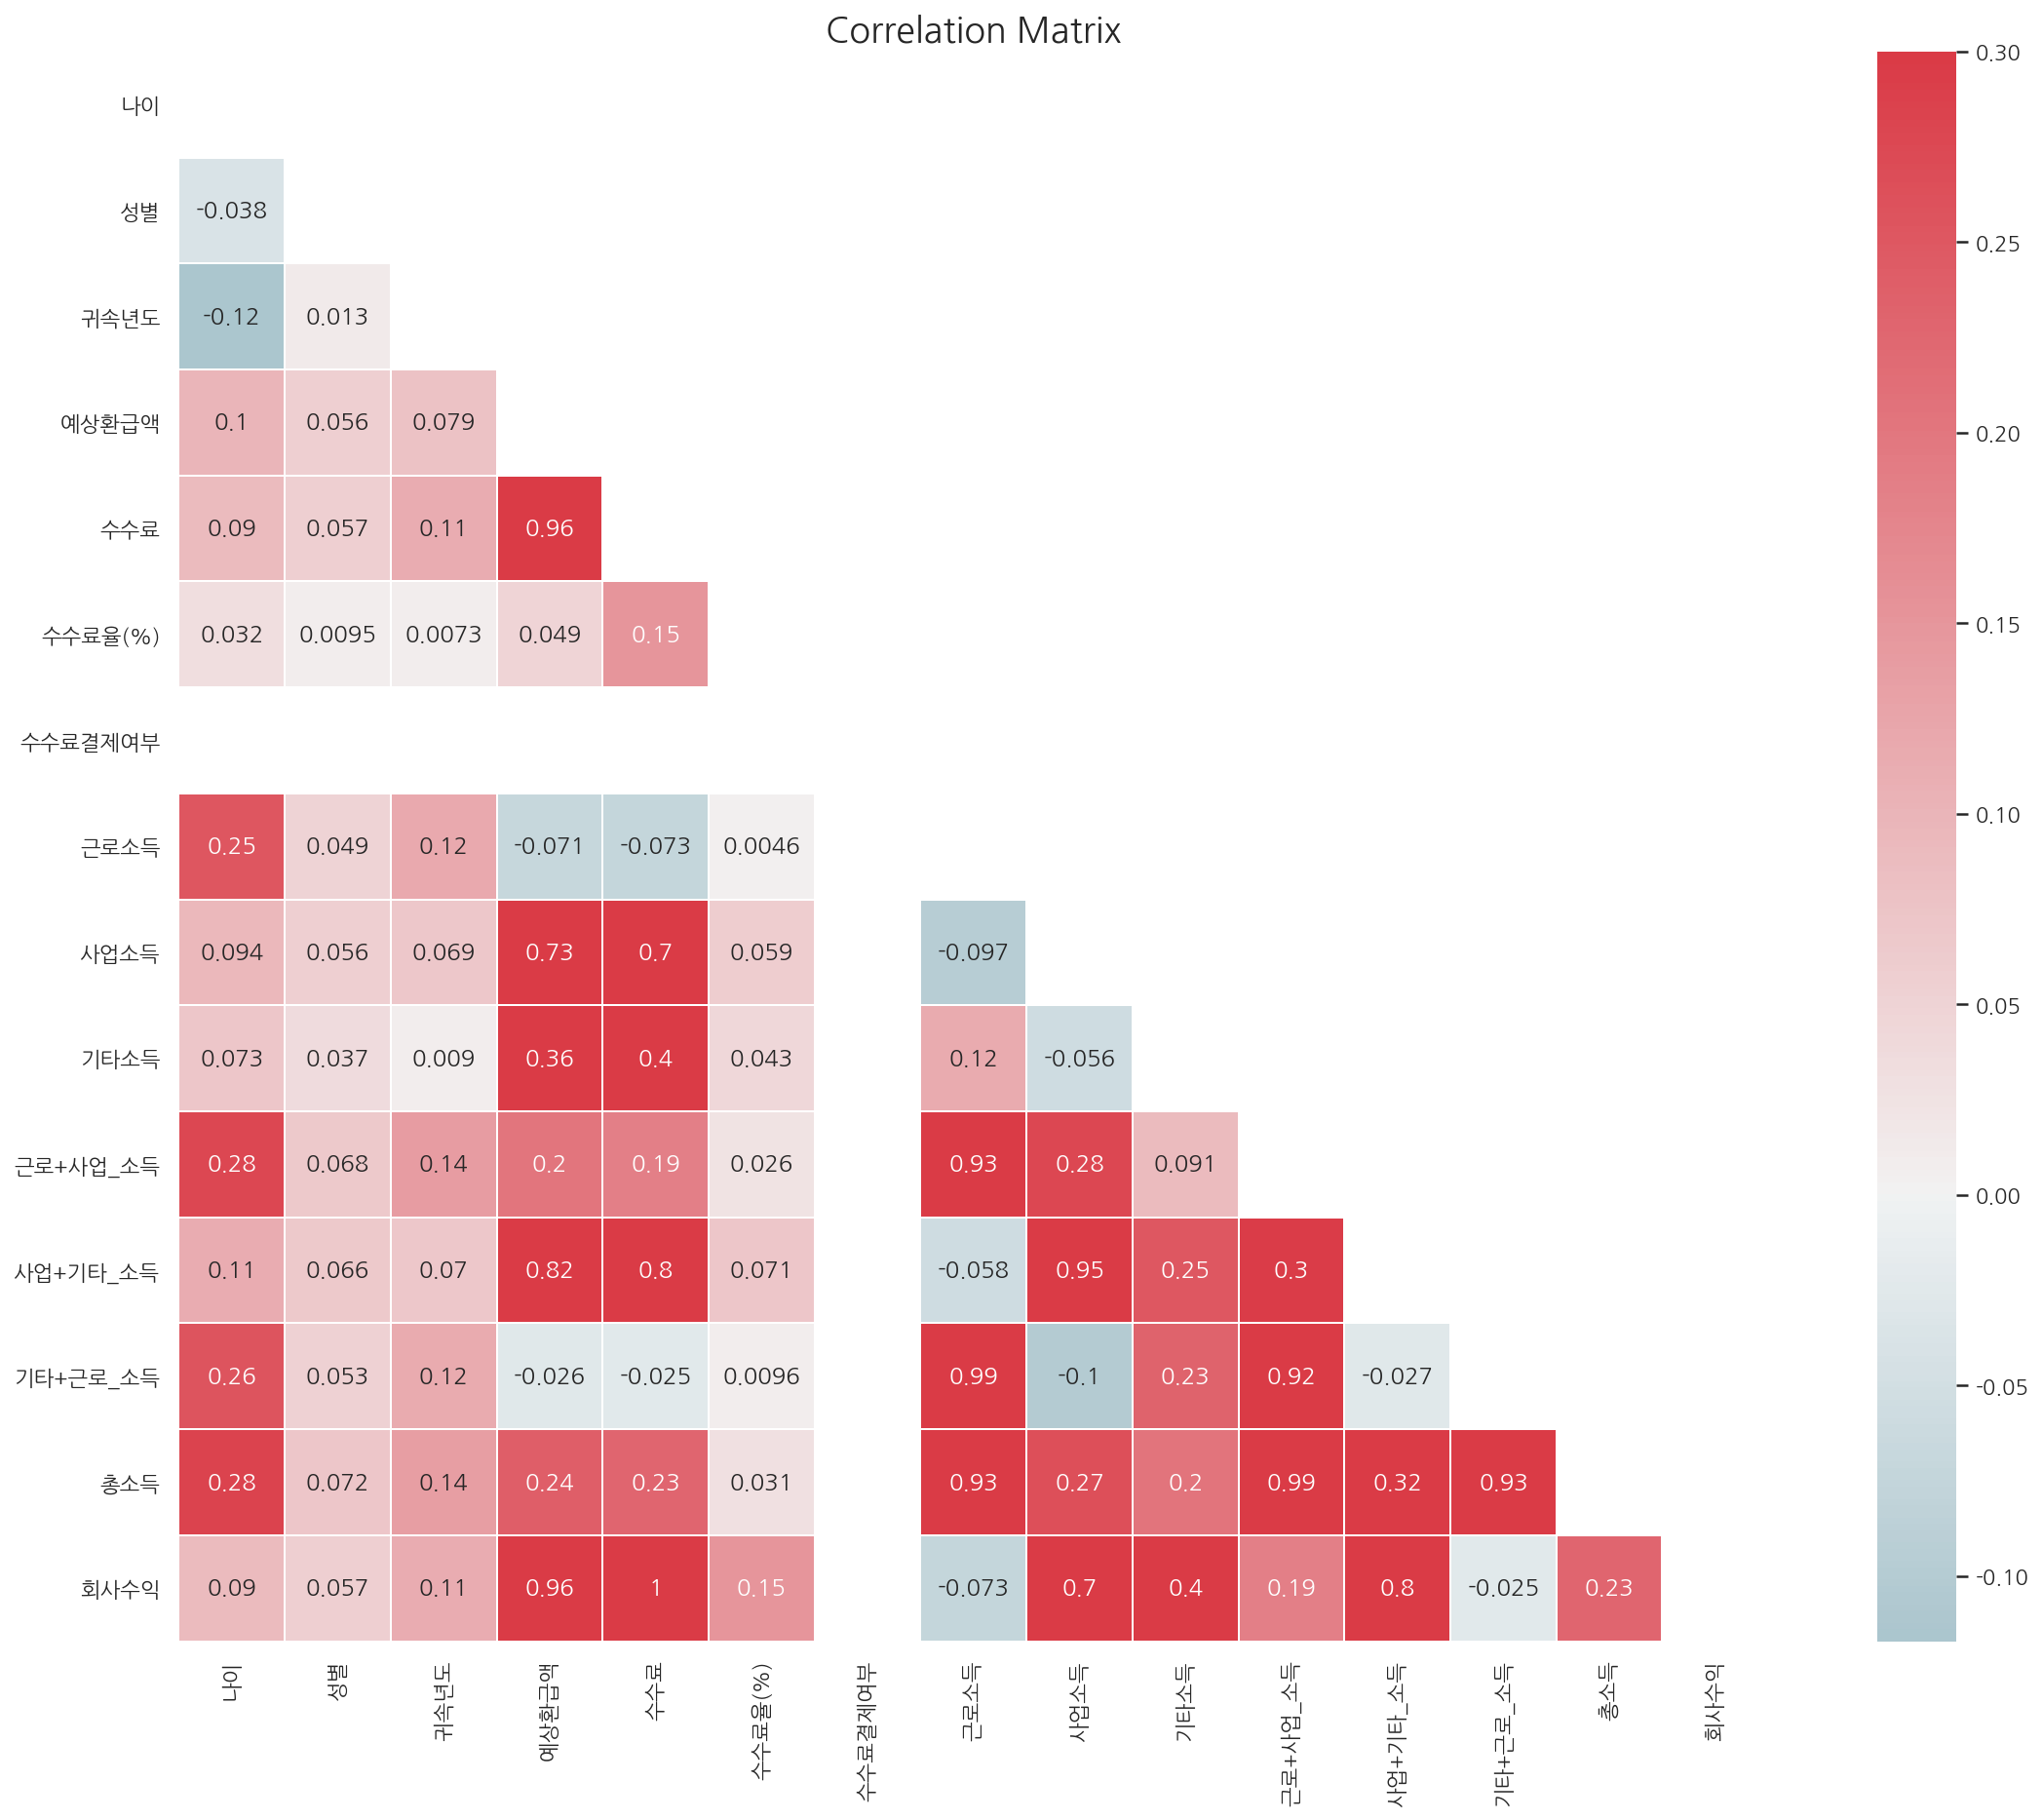

In [321]:
# 회사수익과 상관관계가 높은 항목을 찾기 위한 Correlation Matrix
sns.set(style="white", font='NanumGothic')
corr2 = plus_profit_df.corr()
mask = np.triu(np.ones_like(corr2, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True)
plt.show()

In [322]:
corr_profit_list = corr2.query("회사수익 > 0.3 or 회사수익 < -0.3").index.values.tolist()
corr_profit_list.remove('회사수익')
print(corr_profit_list)

['예상환급액', '수수료', '사업소득', '기타소득', '사업+기타_소득']


In [323]:
list2 = plus_profit_df.columns.to_list()
list2.remove('회사수익')
list2

['나이',
 '성별',
 '귀속년도',
 '예상환급액',
 '수수료',
 '수수료율(%)',
 '수수료결제여부',
 '근로소득',
 '사업소득',
 '기타소득',
 '근로+사업_소득',
 '사업+기타_소득',
 '기타+근로_소득',
 '총소득']

In [324]:
len(list2)

14

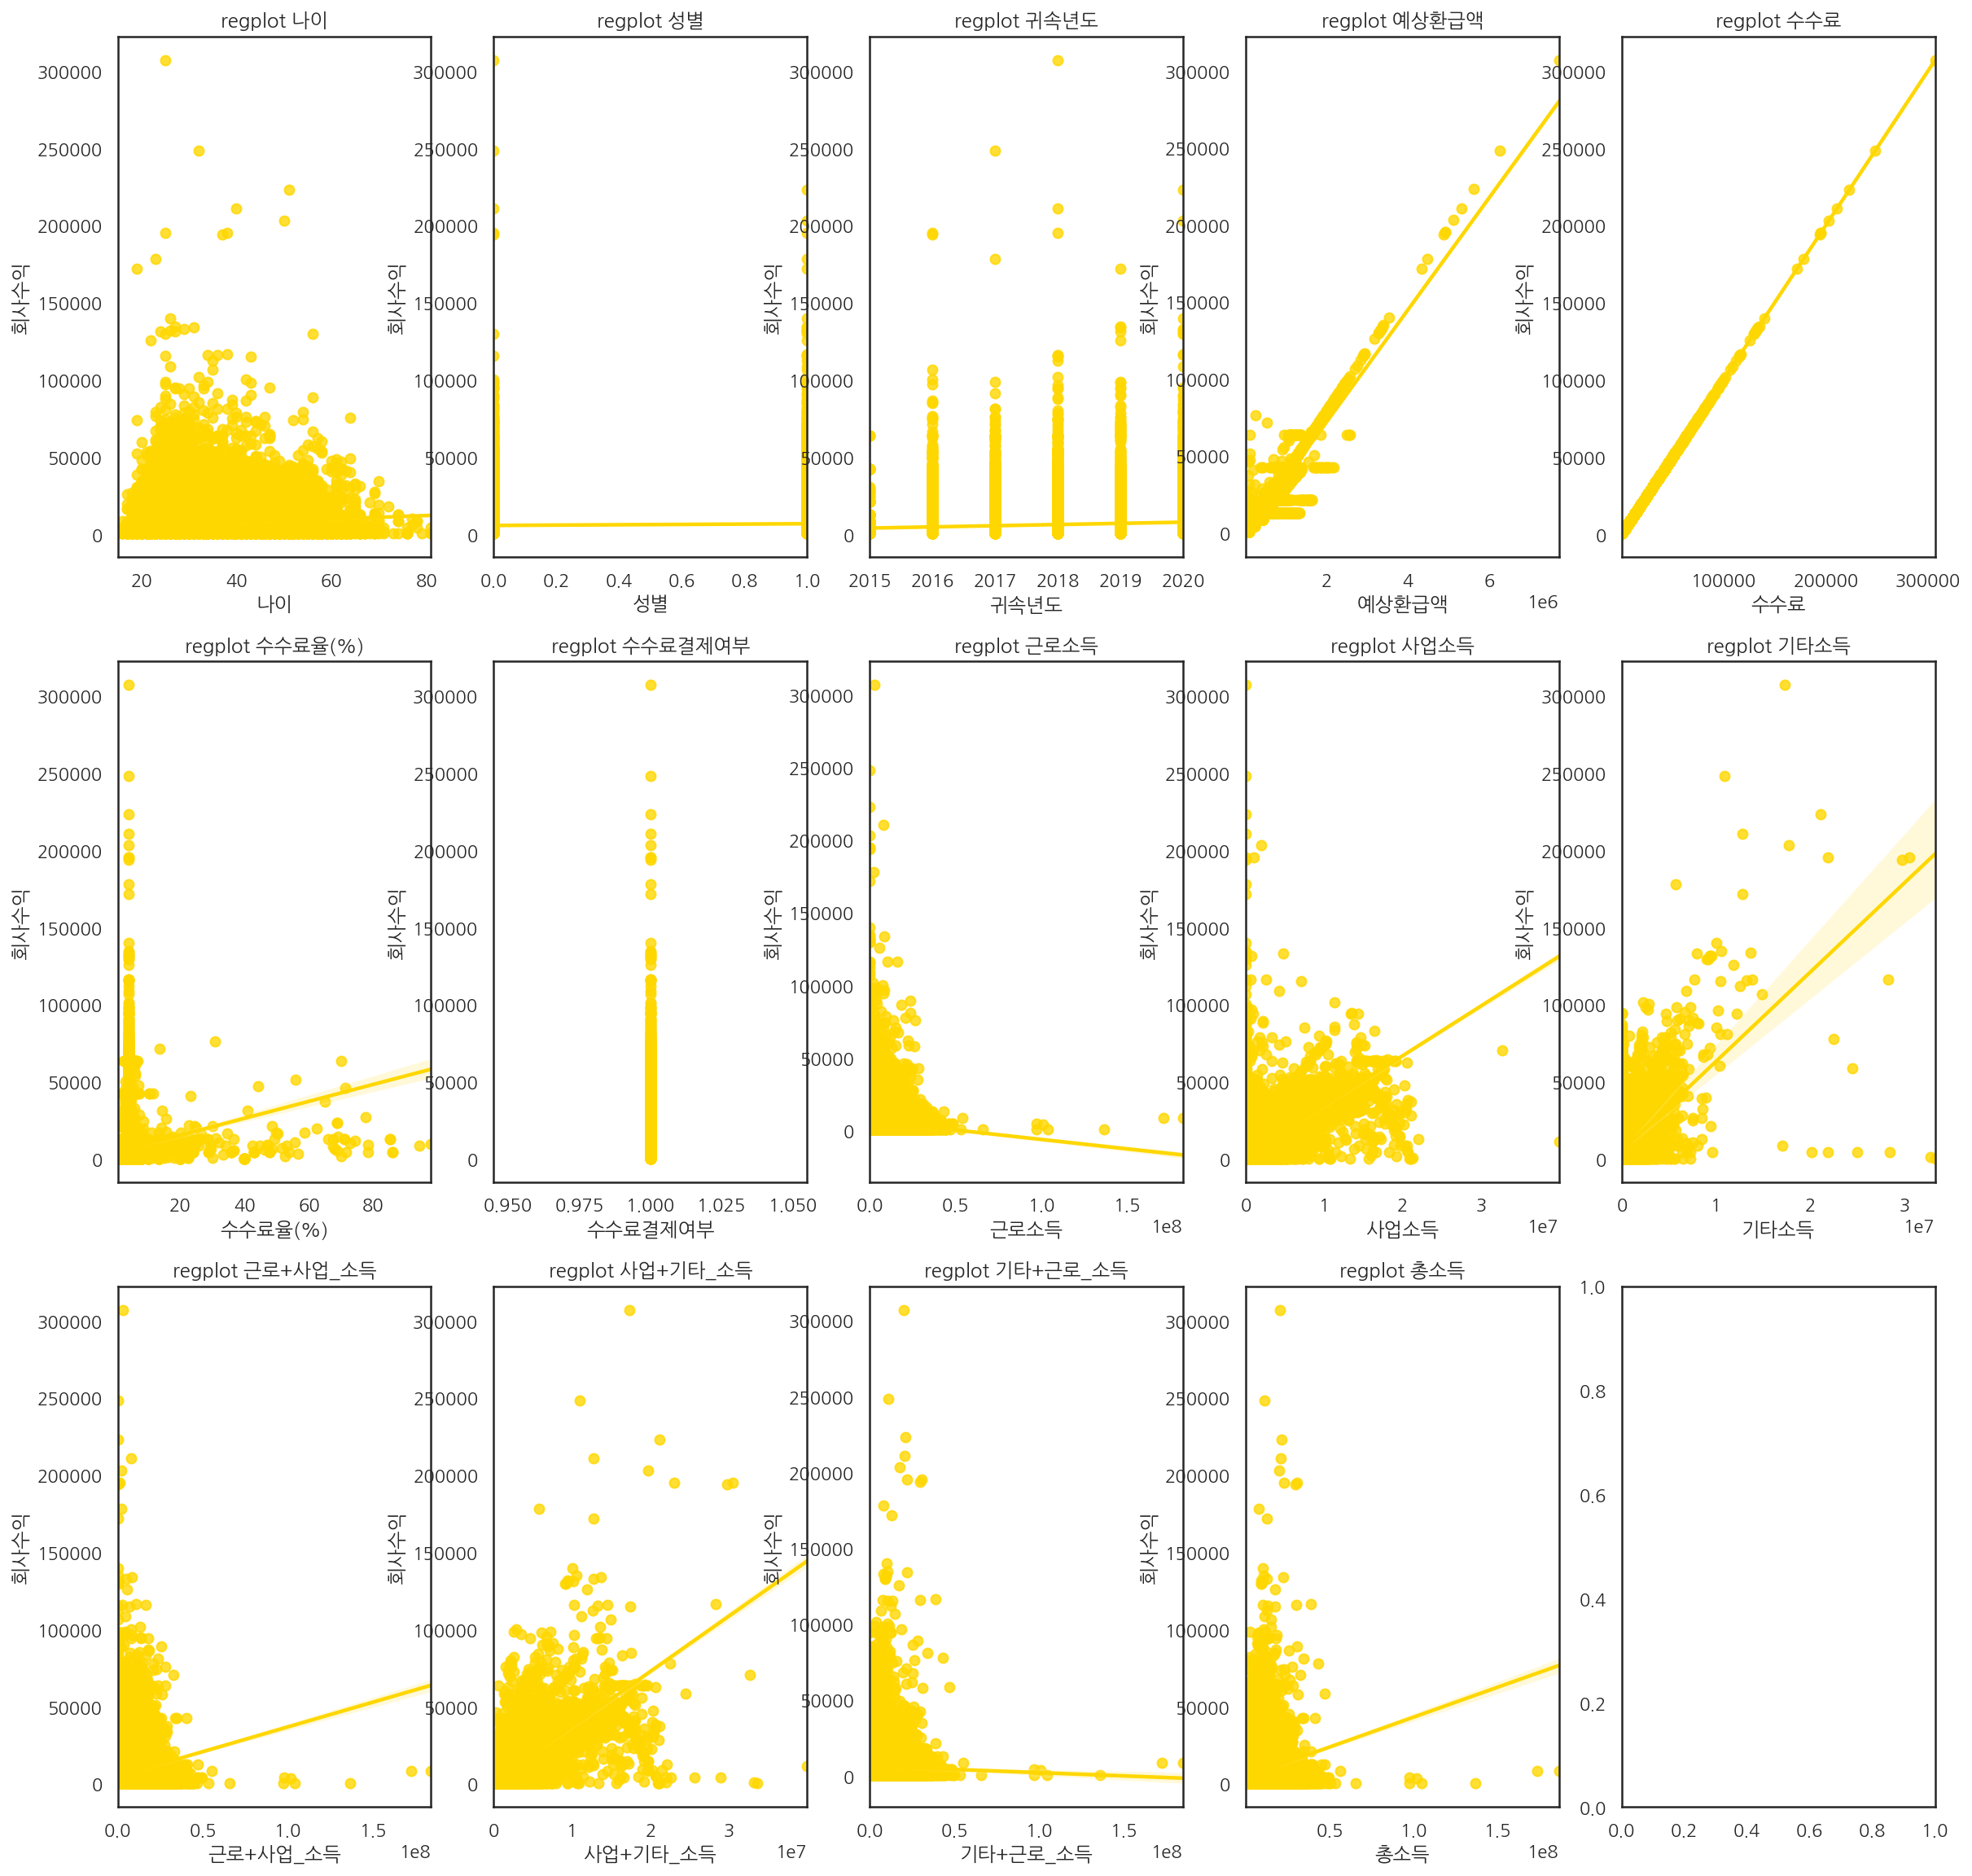

In [264]:
# 회사 수익과 다른 항목들 간의 관계를 regression plot을 통해 시각화
figure, ax_list = plt.subplots(nrows=3, ncols=5)
figure.set_size_inches(20,20)

for i in range(len(list2)): 
    sns.regplot(data=plus_profit_df, x=list2[i], y='회사수익', ax=ax_list[int(i/5)][int(i%5)], color='gold') 
    ax_list[int(i/5)][int(i%5)].set_title("regplot " + list2[i])

> * 회사 수익과 수수료 사이에 1의 정비례하는 상관관계가 있기 때문에, 수수료가 증가해야 회사 수익 역시 증가함을 확인할 수 있다.

> * 회사 수익과 예상환급액 사이에 0.95의 정비례에 근접한 강한 상관관계가 있는 것을 볼 수 있다. 이는 주로 예상환급액이 많은 고객으로부터 회사 수익을 도모할 수 있음을 나타낸다.

> * 회사 수익과 고객의 사업소득 간에 0.69의 비교적 강한 상관관계, 회사 수익과 고객의 (사업+기타)소득 간에 0.79의 강한 상관관계가 있는 것으로 나타났다. 이로 미루어 볼 때, 주로 사업소득을 갖는 고객으로부터 회사 수익을 높일 수 있음을 파악할 수 있다.  

## 수수료를 결제한 고객의 비율 구하기

In [325]:
# 근로소득이 0인 고객 데이터 제외
labor_df = df4.loc[df4['근로소득'] > 0]
paid_labor_df = labor_df.loc[labor_df['수수료결제여부']==1]
# 근로소득 고객 중 수수료를 결제한 고객의 비율
paid_labor_ratio = len(paid_labor_df)/len(labor_df)*100
paid_labor_ratio

69.94078980380351

In [326]:
# 사업소득이 0인 고객 데이터 제외
business_df = df4.loc[df4['사업소득'] > 0]
paid_business_df = business_df.loc[business_df['수수료결제여부']==1]
# 사업소득 고객 중 수수료를 결제한 고객의 비율
paid_business_ratio = len(paid_business_df)/len(business_df)*100
paid_business_ratio

70.93088785286132

In [327]:
# 기타소득이 0인 고객 데이터 제외
extra_df = df4.loc[df4['기타소득'] > 0]
paid_extra_df = extra_df.loc[extra_df['수수료결제여부']==1]
# 기타소득 고객 중 수수료를 결제한 고객의 비율
paid_extra_ratio = len(paid_extra_df)/len(extra_df)*100
paid_extra_ratio

66.24383368569416

> 수수료를 결제하는 고객 중 사업소득을 지닌 고객이 70.93%로 나머지 근로소득과 기타소득에 비해 높음을 확인할 수 있다.
    
    -> 따라서 고객의 수수료 결제금액의 합을 높이기 위해선 사업소득을 갖고 있는 고객들을 많이 유치하는 쪽으로 계획을 세우는 게 필요하다.

### 삼쩜삼 수수료 책정 방법

✅ 삼쩜삼 수수료 책정 기준

| 예상 환급세액의 10~20%
    
    => (수수료/예상환급액)*100 = 수수료율(%)
 

✅ 연도 별로 고객의 소득에 따른 환급액이 다름

| 신고 연도별로 수수료 책정 후 합산

In [268]:
# 정규화 + 확률분포 함수 계산을 위한 라이브러리
from scipy import stats
from math import sqrt, log, exp, pi

from random import uniform

## 수수료를 결제하지 않은 집단

In [367]:
not_paid_df = plus_refund_df.loc[plus_refund_df['수수료결제여부']==0]
not_paid_df.describe()

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
count,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00,27275.00
mean,28.86,0.50,2018.72,274505.74,10469.15,3.62,0.00,2952616.94,1590716.11,267718.46,4543333.05,1858434.57,3220335.40,4811051.51,0.00
std,7.75,0.50,1.40,410697.73,16471.98,2.48,0.00,5515208.60,2817065.13,1136274.96,5765199.56,2954239.36,5699765.11,5899819.98,0.00
min,16.00,0.00,2015.00,1000.00,400.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9000.00,0.00
25%,24.00,0.00,2018.00,33000.00,400.00,1.96,0.00,0.00,43000.00,0.00,366000.00,167000.00,0.00,595000.00,0.00
50%,27.00,0.00,2019.00,124000.00,4700.00,3.89,0.00,0.00,420000.00,0.00,2133000.00,699000.00,272000.00,2456000.00,0.00
75%,31.00,1.00,2020.00,359000.00,14000.00,3.96,0.00,3753000.00,1701000.00,55000.00,7031000.00,2114000.00,4252000.00,7294000.00,0.00
max,78.00,1.00,2020.00,7608000.00,302300.00,96.80,0.00,164883000.00,21224000.00,62810000.00,165103000.00,66319000.00,166500000.00,166720000.00,0.00


## 수수료를 결제하여 수익을 가져다 준 집단

In [368]:
plus_profit_df.describe()

,나이,성별,귀속년도,예상환급액,수수료,수수료율(%),수수료결제여부,근로소득,사업소득,기타소득,근로+사업_소득,사업+기타_소득,기타+근로_소득,총소득,회사수익
count,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00,62452.00
mean,28.86,0.51,2017.99,188458.34,6271.10,3.15,1.00,2905209.89,1197128.80,137395.38,4102338.69,1334524.18,3042605.26,4239734.07,6271.10
std,7.68,0.50,1.45,255852.01,9696.59,2.68,0.00,5452406.11,2089560.89,662792.29,5647530.46,2156209.74,5567994.12,5745616.46,9696.59
min,15.00,0.00,2015.00,1000.00,400.00,0.56,1.00,0.00,0.00,0.00,0.00,0.00,0.00,9000.00,400.00
25%,24.00,0.00,2017.00,35000.00,400.00,1.76,1.00,0.00,104000.00,0.00,367000.00,202000.00,0.00,459000.00,400.00
50%,27.00,1.00,2018.00,95000.00,3000.00,2.87,1.00,0.00,450000.00,0.00,1575000.00,584000.00,170000.00,1692000.00,3000.00
75%,31.00,1.00,2019.00,235000.00,8500.00,3.93,1.00,3817000.00,1294000.00,9000.00,6111000.00,1454000.00,3972250.00,6211000.00,8500.00
max,81.00,1.00,2020.00,7725000.00,307000.00,98.00,1.00,182335000.00,39934000.00,33235000.00,183916000.00,39934000.00,185064000.00,186645000.00,307000.00


 ```수수료를 결제한 집단: 평균수수료 = 6271.10원 | 평균수수료율(%) = 3.15% 
수수료를 결제하지 않은 집단: 평균수수료 = 10469.15원 | 평균수수료율(%) = 3.62%```

### 수수료를 결제한 집단에서 귀속년도와 예상환급액 별로 수수료율이 어떻게 책정되는지 확인

In [370]:
# 귀속년도별 환급세액 구간별 평균수수료율(%)
paid_rate_df = pd.DataFrame(plus_profit_df.groupby(['귀속년도','예상환급액'])['수수료율(%)','수수료','수수료결제여부','회사수익'].mean())
paid_rate_df

수수료율(%)       수수료  수수료결제여부      회사수익
귀속년도 예상환급액                                           
2015 4000.00       10.00    400.00        1    400.00
     5000.00        8.00    400.00        1    400.00
     6000.00        6.67    400.00        1    400.00
     7000.00        5.71    400.00        1    400.00
     8000.00        5.00    400.00        1    400.00
...                  ...       ...      ...       ...
2020 3325000.00     3.96 131800.00        1 131800.00
     3347000.00     3.98 133100.00        1 133100.00
     3525000.00     3.97 139900.00        1 139900.00
     5119000.00     3.97 203200.00        1 203200.00
     5620000.00     3.97 223200.00        1 223200.00

[5742 rows x 4 columns]

In [371]:
pr_mean = paid_rate_df.groupby(['귀속년도']).mean()
pr_mean

,수수료율(%),수수료,수수료결제여부,회사수익
귀속년도,,,,
2015,2.68,9912.63,1,9912.63
2016,3.27,17856.84,1,17856.84
2017,3.35,18868.49,1,18868.49
2018,3.35,20545.53,1,20545.53
2019,3.37,20047.66,1,20047.66
2020,3.80,26528.27,1,26528.27


### 수수료를 결제하지 않은 집단에서 귀속년도와 예상환급액 별로 수수료율이 어떻게 책정되는지 확인

In [372]:
notpaid_rate_df = pd.DataFrame(not_paid_df.groupby(['귀속년도','예상환급액'])['수수료율(%)','수수료','수수료결제여부','회사수익'].mean())
notpaid_rate_df

수수료율(%)       수수료  수수료결제여부  회사수익
귀속년도 예상환급액                                       
2015 3000.00       13.33    400.00        0  0.00
2016 2000.00       20.00    400.00        0  0.00
     3000.00       13.33    400.00        0  0.00
     4000.00       10.00    400.00        0  0.00
     5000.00        8.00    400.00        0  0.00
...                  ...       ...      ...   ...
2020 5580000.00     3.97 221500.00        0  0.00
     5595000.00     3.97 222400.00        0  0.00
     6000000.00     3.98 238500.00        0  0.00
     6054000.00     3.97 240600.00        0  0.00
     6815000.00     3.97 270800.00        0  0.00

[4519 rows x 4 columns]

In [373]:
npr_mean = notpaid_rate_df.groupby(['귀속년도']).mean()
npr_mean

,수수료율(%),수수료,수수료결제여부,회사수익
귀속년도,,,,
2015,13.33,400.00,0,0.00
2016,3.68,17738.13,0,0.00
2017,3.70,19443.46,0,0.00
2018,3.78,21679.74,0,0.00
2019,3.76,22678.54,0,0.00
2020,3.86,38452.23,0,0.00


In [377]:
# 귀속년도별 수수료 결제 여부가 다른 두 집단에서 책정된 수수료율 비교
pr_mean - npr_mean

,수수료율(%),수수료,수수료결제여부,회사수익
귀속년도,,,,
2015,-10.65,9512.63,1,9912.63
2016,-0.42,118.71,1,17856.84
2017,-0.35,-574.97,1,18868.49
2018,-0.43,-1134.21,1,20545.53
2019,-0.39,-2630.88,1,20047.66
2020,-0.07,-11923.96,1,26528.27


> 수수료를 결제한 집단에서 각 년도별 평균수수료율이 낮게 책정됨이 확인됨

### 수수료를 결제하지 않은 집단에서 귀속년도와 환급세액별로 책정된 수수료율을 수수료를 결제한 집단에서 책정된 수수료율로 낮출 경우 얻을 수 있는 회사수익의 기대증가분

In [407]:
# 회사수익 = Σ(수수료*수수료결제여부)
# 수수료 = 예상환급액*수수료율
rate_replace = npr_mean.replace(npr_mean['수수료율(%)'], pr_mean['수수료율(%)'], inplace=True)
rate_replace

In [408]:
print(rate_replace)

None


In [389]:
rate_replace_df = pd.DataFrame(rate_replace)
print(rate_replace_df.shape())

In [384]:
notpaid_rate_df.groupby(['귀속년도'])['수수료율(%)'].mean().replace()


fish = pd.DataFrame(notpaid_rate_df.groupby(['예상환급액']).mean()==paid_rate_df.groupby(['예상환급액']).mean())
fish

ValueError: Can only compare identically-labeled DataFrame objects

In [ ]:
rate_replace_df = notpaid_rate_df.replace(['수수료율(%)'], paid_rate_df['수수료율(%)'], inplace=True)
rate_relace_df

# 회사수익 극대화 알고리즘: EM algorithm

## EM 알고리즘
* Em 알고리즘은 크게 E-step과 M-step 2단계로 나누어 이 과정을 반복하면서 최적의 파라미터에 근사한 값을 찾아가는 알고리즘이다.

* E-step : 주어진 임의의 파라미터 초기값에서 Likelihood와 최대한 근사한 likelihood값을 계산한다.

* M-step : E-step에서 계산된 likelihood를 최대화(maximize)하는 새로운 파라미터값을 얻는다.

> 위 2단계를 파라미터값이 크게변하지 않을 때까지 계속적으로 반복한다.

> EM알고리즘의 목적은 주어진 데이터 x에 대해 가능도 p(x∣θ)를 가장 크게 하는 잠재변수에 대한 확률분포 q(z)와 θ를 구하는 것이다.


* 출처: 
    * https://techblog-history-younghunjo1.tistory.com/88
    * 데이터 사이언스 스쿨https://datascienceschool.net/03%20machine%20learning/18.01%20%EA%B0%80%EC%9A%B0%EC%8B%9C%EC%95%88%20%ED%98%BC%ED%95%A9%EB%AA%A8%ED%98%95%EA%B3%BC%20EM%20%EB%B0%A9%EB%B2%95.html

## 수수료

Input Gaussian 1: μ = 1.047e+04, σ = 1.647e+04
Input Gaussian 2: μ = 6.271e+03, σ = 9.697e+03


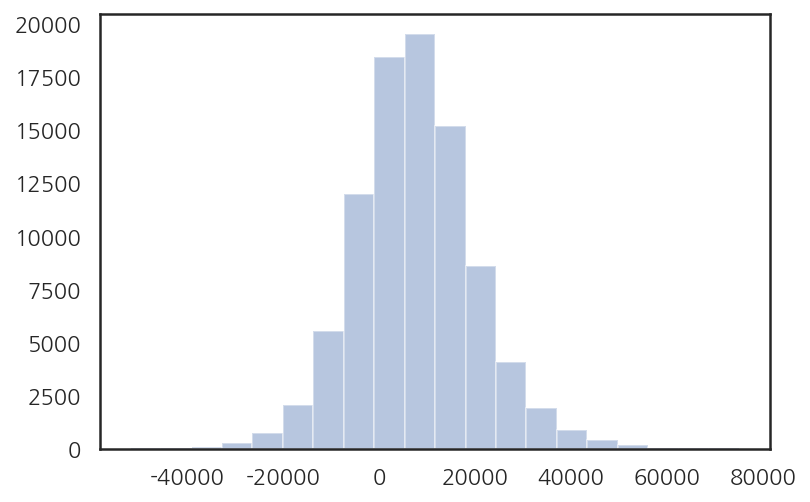

In [272]:
random_seed=89727
np.random.seed(random_seed)

# 인풋 파라미터(=정규분포의 평균, 표준편차)
mean1 = 10469.15
standard_dev1 = 16471.98
mean2 = 6271.10
standard_dev2 = 9696.59

# y1, y2값 생성
y1 = np.random.normal(mean1, standard_dev1, 27275)
y2 = np.random.normal(mean2, standard_dev2, 62452)
data=np.append(y1,y2)

# 그래프 시각화 통해 데이터 분포 확인
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000)

print('Input Gaussian {:}: μ = {:.4}, σ = {:.4}'.format("1", mean1, standard_dev1))
print('Input Gaussian {:}: μ = {:.4}, σ = {:.4}'.format("2", mean2, standard_dev2))
sns.distplot(data, bins=20, kde=False);

In [273]:
# 가우시안 모형
class Gaussian:

    def __init__(self, mu, sigma):
        # 평균, 표준편차 설정
        self.mu = mu
        self.sigma = sigma

    #확률분포 함수 
    def pdf(self, datum):
        "주어진 파라미터에 대한 데이터 값의 확률"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

Best single Gaussian: μ = 7.583e+03, σ = 1.232e+04


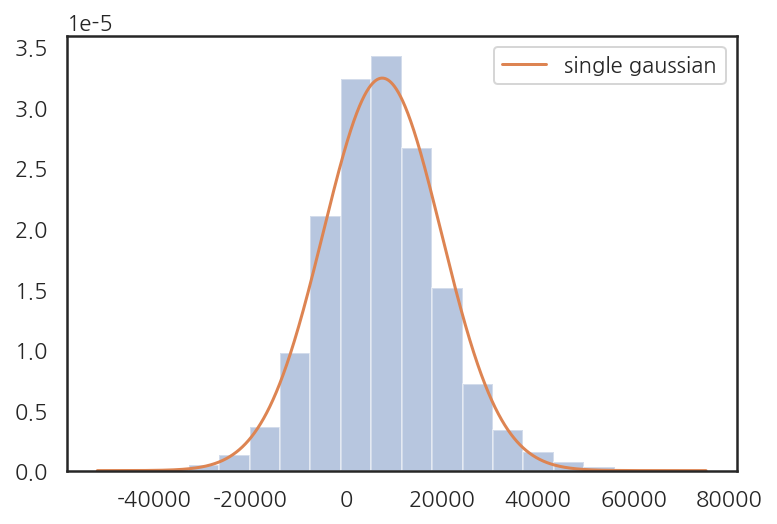

In [274]:
# 데이터 분포에 최적화된 가우시안 모형
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.4}, σ = {:.4}'.format(best_single.mu, best_single.sigma))

# 데이터 분포를 커버하는 최적화된 가우시안 곡선 그리기
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True);
plt.plot(x, g_single, label='single gaussian');
plt.legend();

## 수수료율

Input Gaussian 1: μ = 3.62, σ = 2.48
Input Gaussian 2: μ = 3.15, σ = 2.68


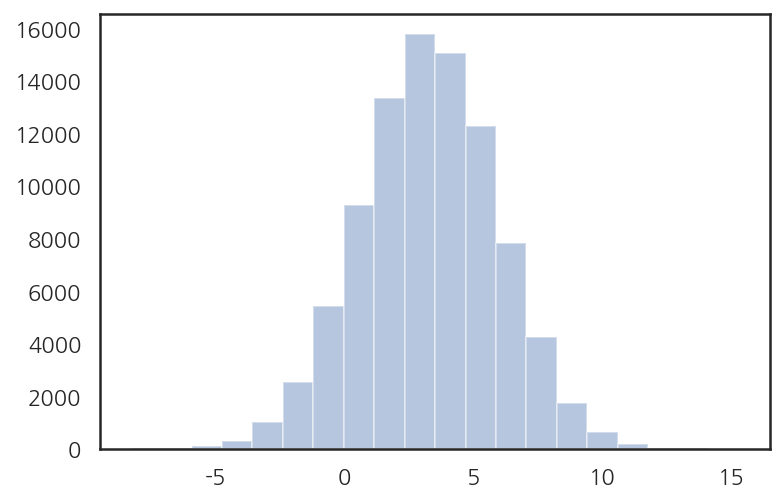

In [275]:
random_seed=89727
np.random.seed(random_seed)

# 인풋 파라미터(=정규분포의 평균, 표준편차)
mean1 = 3.62  
standard_dev1 = 2.48
mean2 = 3.15
standard_dev2 = 2.68

# y1, y2값 생성
y1 = np.random.normal(Mean1, Standard_dev1, 27275)
y2 = np.random.normal(Mean2, Standard_dev2, 62452)
data=np.append(y1,y2)

# 그래프 시각화 통해 데이터 분포 확인
Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000)

print('Input Gaussian {:}: μ = {:.4}, σ = {:.4}'.format("1", mean1, standard_dev1))
print('Input Gaussian {:}: μ = {:.4}, σ = {:.4}'.format("2", mean2, standard_dev2))
sns.distplot(data, bins=20, kde=False);

In [276]:
# 가우시안 모형
class Gaussian:
    
    def __init__(self, mu, sigma):
        #mean and standard deviation
        self.mu = mu
        self.sigma = sigma

    # 확률분포 함수 
    def pdf(self, datum):
        "주어진 파라미터에 대한 데이터 값의 확률"
        u = (datum - self.mu) / abs(self.sigma)
        y = (1 / (sqrt(2 * pi) * abs(self.sigma))) * exp(-u * u / 2)
        return y
    
    def __repr__(self):
        return 'Gaussian({0:4.6}, {1:4.6})'.format(self.mu, self.sigma)

Best single Gaussian: μ = 3.298, σ = 2.629


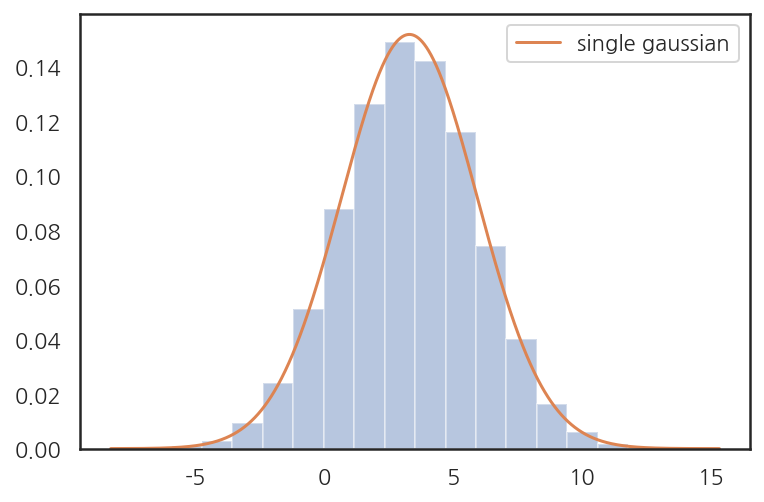

In [277]:
# 데이터 분포에 최적화된 가우시안 모형
best_single = Gaussian(np.mean(data), np.std(data))
print('Best single Gaussian: μ = {:.4}, σ = {:.4}'.format(best_single.mu, best_single.sigma))

# 데이터 분포를 커버하는 최적화된 가우시안 곡선 그리기
g_single = stats.norm(best_single.mu, best_single.sigma).pdf(x)
sns.distplot(data, bins=20, kde=False, norm_hist=True);
plt.plot(x, g_single, label='single gaussian');
plt.legend();